In [1]:
# import inspect  ### tool to inspect the code of an imported function

In [2]:
import gammapy
print(gammapy.__version__)

0.19


In [3]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler, Datasets
from gammapy.estimators import FluxPointsEstimator
from gammapy.maps import MapAxis, WcsGeom, Map, MapAxes, MapCoord
from gammapy.irf import load_cta_irfs
from gammapy.makers import MapDatasetMaker, FoVBackgroundMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
#     Model,
#     Models,
    SkyModel,
#     PowerLawSpectralModel,
#     PowerLawNormSpectralModel,
#     PointSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
#     TemplateSpatialModel,
#     ExpDecayTemporalModel,
#     LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
)
from gammapy.maps.geom import pix_tuple_to_idx
import warnings

In [4]:
class EventDataset():
    stat_type = "cash"
    tag = "EventDataset"
    
    def __init__(self, MapDataset, events_table, name='test-eds'):
        """
        MapDataset: gammapy.datasets.MapDataset with the IRFs
        events_table: astropy.table.Table with the event data
        """
        self.ds = MapDataset.copy(name=MapDataset.name)
        self.ds.models = MapDataset.models.copy()
        self.tab = events_table
        self.name = name
        self.meta_table=None
        
    @property
    def models(self):
        return self.ds.models
        
    def stat_sum(self):
        """
        Calculating the TS value for the unbinned dataset. 
        Essentially interpolating the npred cube at the events 
        positions (ra,dec,energy) and summing the log of those values.
        """
        npred = self.ds.npred()
        # need to mask the total npred so only regions contibute where events are
        mask = self.ds.mask_safe.data
        npred_tot = npred.data[mask].sum()
        # set the event coords from table
        coords = MapCoord.create((self.tab["RA"].quantity.to('deg'),
                                 self.tab["DEC"].quantity.to('deg'),
                                 self.tab["ENERGY"].quantity.to('TeV')), 
                                 frame='icrs', axis_names=['energy'])
        # interpolate the predicted counts
        response = npred.interp_by_coord(coords, method='linear', fill_value=0)
        # if npred = 0 at some events position the model is rouled out (TS=inf)
        if np.all(response>0):
            logL = np.sum(np.log(response)) - npred_tot
        else:
#             print(np.where(response==0))
            return np.inf
        return -2 * logL

    def contribution_events(self):
        """
        compute the contribution of each event to the total likelihood
        """
        nevents = len(self.tab)
        npred = self.ds.npred()
        npred_tot = npred.data.sum()
        # set the event coords from table
        coords = MapCoord.create((self.tab["RA"].quantity.to('deg'),
                                 self.tab["DEC"].quantity.to('deg'),
                                 self.tab["ENERGY"].quantity.to('TeV')), 
                                 frame='icrs', axis_names=['energy'])
        # interpolate the predicted counts
        response = npred.interp_by_coord(coords, method='linear', fill_value=0)
        return (np.log(response) - npred_tot/nevents) * -2.
    
    def contribution_bins(self):
        """
        compute the contribution of each event in the binned likelihood
        """
        
        stat_array = self.ds.stat_array()
        counts = self.ds.counts
        contrib=[]
        indices=[]
        coordinates=[]
        for row in self.tab:
            c=MapCoord.create((row["RA"]*self.tab["RA"].unit,
                                 row["DEC"]*self.tab["DEC"].unit,
                                 row["ENERGY"]*self.tab["ENERGY"].unit), 
                                 frame='icrs', axis_names=['energy'])
            idx = counts.geom.coord_to_idx(c)
            nevents = counts.get_by_idx(idx)
            contrib.append(stat_array.T[idx]/nevents)
            indices.append(idx)
            coordinates.append(c)
        return np.array(contrib), np.array(indices), np.array(coordinates)

# Create Binned MapDataset

In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

In [6]:
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]
# selection = dict(
#     type="sky_circle",
#     frame="icrs",
#     lon="83.633 deg",
#     lat="22.014 deg",
#     radius="5 deg",
# )
# selected_obs_table = data_store.obs_table.select_observations(selection)

No HDU found matching: OBS_ID = 23523, HDU_TYPE = rad_max, HDU_CLASS = None


In [7]:
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos = obs1.pointing_radec
# choose energy binning
ebins = np.geomspace(0.6,100,25)
ebins_true = np.logspace(-1,2,73)

energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins_true, unit="TeV", name="energy_true", interp="log"  
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.05,
    width=(3.5, 3.5),
    frame="icrs",  # same frame as events
    proj="CAR",
    axes=[energy_axis],
)

circle = CircleSkyRegion(
    center=crab_pos, radius=0.3 * u.deg
)
data = geom.region_mask(regions=[circle], inside=False)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [8]:
%%time
maker = MapDatasetMaker(background_oversampling=2)
maker_safe_mask = SafeMaskMaker(methods=['offset-max', 'aeff-default'], offset_max='1.5 deg')
reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)  

dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)

# assert np.isfinite(dataset.background.data[dataset.mask_safe.data]).all()
# dataset.background.data[~dataset.mask_safe.data] = 0.0

bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
dataset.models=bkg_model
dataset.background_model.spectral_model.tilt.frozen = False
dataset = maker_fov.run(dataset)
print(
    f"Background norm obs {obs1.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f} \
    (tilt={dataset.background_model.spectral_model.tilt.value:.2f})"
)

Background norm obs 23523: 0.84     (tilt=-0.11)
CPU times: user 3.41 s, sys: 587 ms, total: 4 s
Wall time: 4.01 s


In [9]:
model_gauss = SkyModel(
    spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.016 deg', frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )

model_gauss.spatial_model.parameters.freeze_all()
model_gauss.spectral_model.amplitude.min = 0.
model_gauss.spectral_model.alpha.min = 0.
model_gauss.spectral_model.beta.min = 0.
model_gauss.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,int64,float64,float64,bool,str1
spectral,amplitude,3.5000e-11,cm-2 s-1 TeV-1,0.000e+00,0.000e+00,nan,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
spectral,alpha,1.8000e+00,,0.000e+00,0.000e+00,nan,False,
spectral,beta,4.0000e-01,,0.000e+00,0.000e+00,nan,False,
spatial,lon_0,1.8456e+02,deg,0.000e+00,nan,nan,True,
spatial,lat_0,-5.7840e+00,deg,0.000e+00,-9.000e+01,9.000e+01,True,
spatial,sigma,1.6000e-02,deg,0.000e+00,0.000e+00,nan,True,
spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,
spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,


In [10]:
dataset.models += model_gauss

In [11]:
print(dataset)

MapDataset
----------

  Name                            : IHnUFQyd 

  Total counts                    : 1385 
  Total background counts         : 1332.99
  Total excess counts             : 52.01

  Predicted counts                : 1379.30
  Predicted background counts     : 1219.23
  Predicted excess counts         : 160.07

  Exposure min                    : 3.35e+06 m2 s
  Exposure max                    : 1.10e+09 m2 s

  Number of total bins            : 117600 
  Number of fit bins              : 59388 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 10724.55

  Number of models                : 2 
  Number of parameters            : 12
  Number of free parameters       : 5

  Component 0: FoVBackgroundModel
  
    Name                      : IHnUFQyd-bkg
    Datasets names            : ['IHnUFQyd']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :      0.841   +/-    0.03             
     

# Create the Unbinned Dataset
Only use those events that are also filled in the counts cube for better comparison

In [12]:
ev_table=obs1.events.table[["EVENT_ID",
                            "TIME",
                            "RA",
                            "DEC", 
                            "ENERGY",]]
#                             'FOV_RADEC_THETA']] # FOV_RADEC_THETA = offset (not present in this event list here)

In [13]:
pointing = obs1.pointing_radec
event_skycoords = SkyCoord(ev_table["RA"].quantity, 
                           ev_table["DEC"].quantity, frame = 'icrs')
mask_offset = pointing.separation(event_skycoords).to_value('deg')<=1.5+0.0016 # small tolerance dependent of pixel size

ers = dataset.energy_range_safe[0]
i,j = ers.data.shape
emin=ers.data[i//2,j//2] * ers.unit  # emin from central pixels
tab_mask = (ev_table['ENERGY'] >= emin) & \
            (ev_table['ENERGY'] <= 100.*u.TeV) &\
            mask_offset &  (ev_table["RA"]>60*u.deg)
eds = EventDataset(dataset, ev_table[tab_mask])

In [14]:
# make sure same number of events in both data sets
len(eds.tab),dataset.counts.data[dataset.mask_safe.data].sum()

(1385, 1385.0)

# Fit both datasets and compare

In [15]:
%%time
fit = Fit(optimize_opts={"print_level": 0})
result = fit.run([dataset])
print(result)
result.parameters.free_parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 156
	total stat : 10721.32

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 156
	total stat : 10721.32


CPU times: user 1.18 s, sys: 2.66 ms, total: 1.19 s
Wall time: 1.19 s


type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,float64,float64,float64,bool,str1
spectral,norm,8.3780e-01,,3.467e-02,nan,nan,False,
spectral,tilt,-1.0410e-01,,3.736e-02,nan,nan,False,
spectral,amplitude,4.5933e-11,cm-2 s-1 TeV-1,6.322e-12,0.000e+00,nan,False,
spectral,alpha,2.2851e+00,,3.392e-01,0.000e+00,nan,False,
spectral,beta,2.2312e-01,,1.588e-01,0.000e+00,nan,False,


In [16]:
eds.stat_sum()

10690.636000131368

In [17]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result2 = fit.run([eds])
    print(result2)
result2.parameters.free_parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 152
	total stat : 10684.17

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 152
	total stat : 10684.17


CPU times: user 1.23 s, sys: 0 ns, total: 1.23 s
Wall time: 1.23 s


type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,float64,float64,float64,bool,str1
spectral,norm,8.5027e-01,,3.523e-02,nan,nan,False,
spectral,tilt,-8.2729e-02,,3.806e-02,nan,nan,False,
spectral,amplitude,4.9860e-11,cm-2 s-1 TeV-1,6.476e-12,0.000e+00,nan,False,
spectral,alpha,2.5622e+00,,3.252e-01,0.000e+00,nan,False,
spectral,beta,1.0584e-01,,1.424e-01,0.000e+00,nan,False,


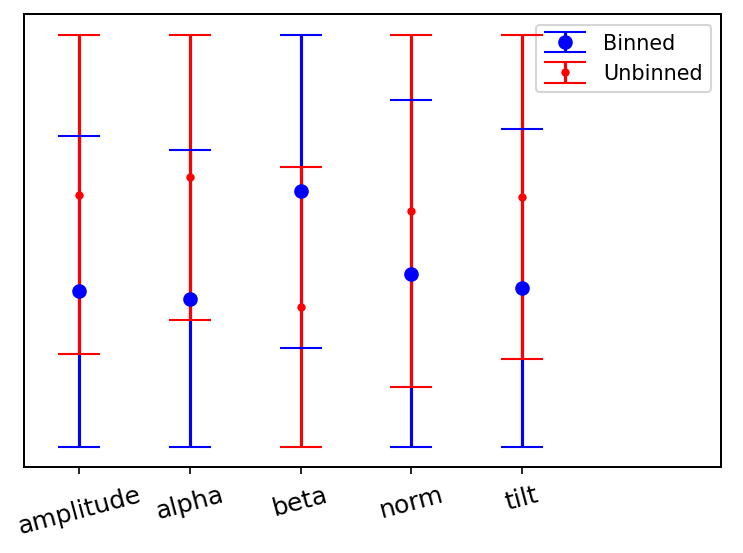

In [18]:
## parameter comparison
params=['amplitude', 'alpha', 'beta', 'norm', 'tilt']
x_values = np.arange(len(params))
best_fit_binned = {par:result.parameters[par].value for par in params}
error_binned = {par:result.parameters[par].error for par in params}

best_fit_unbinned = {par:result2.parameters[par].value for par in params}
error_unbinned = {par:result2.parameters[par].error for par in params}

fig,ax = plt.subplots(dpi=150)
for i,par in enumerate(params):
    if i == 0:
        axi = ax
        label = ['Binned', 'Unbinned']
    else:
        axi = ax.twinx()
        label = None, None
    axi.errorbar(i, best_fit_binned[par],yerr=error_binned[par], 
                 label=label[0],capsize=10, fmt='bo')
    axi.errorbar(i, best_fit_unbinned[par],yerr=error_unbinned[par], 
                 label=label[1],capsize=10, fmt='ro',markersize=3)
    axi.set_yticks([])
ax.legend()
# ax.set_ylabel('Amplitude [1/(TeV*s*cm²)]')
ax.tick_params(axis='x', rotation=15, labelsize=12)

# ax2.errorbar(1, best_fit_fermi[1], yerr=error_fermi[1], capsize=10, fmt='bo')
# ax2.errorbar(1, best_fit_gp[1],yerr=error_gp[1], label='$\gamma\pi$',capsize=10, fmt='ro')
# ax2.set_ylabel('Alpha scale')

# ax3.errorbar(2, best_fit_fermi[2], yerr=error_fermi[2], capsize=10, fmt='bo')
# ax3.errorbar(2, best_fit_gp[2],yerr=error_gp[2], label='$\gamma\pi$',capsize=10, fmt='ro')
# ax3.set_yticks([])
#ax.set_xticklabels(['amplitude'])
plt.xticks(x_values, params, rotation=20, fontsize=20)
#ax1.set_xticks(rotation = 90)
plt.xlim(-0.5,len(params)+0.8)
plt.show()

In [19]:
%%time
fpe = FluxPointsEstimator(energy_axis.edges, source='crab_model_gauss', selection_optional='all')
fp = fpe.run([dataset])

CPU times: user 34.5 s, sys: 700 ms, total: 35.2 s
Wall time: 35.2 s


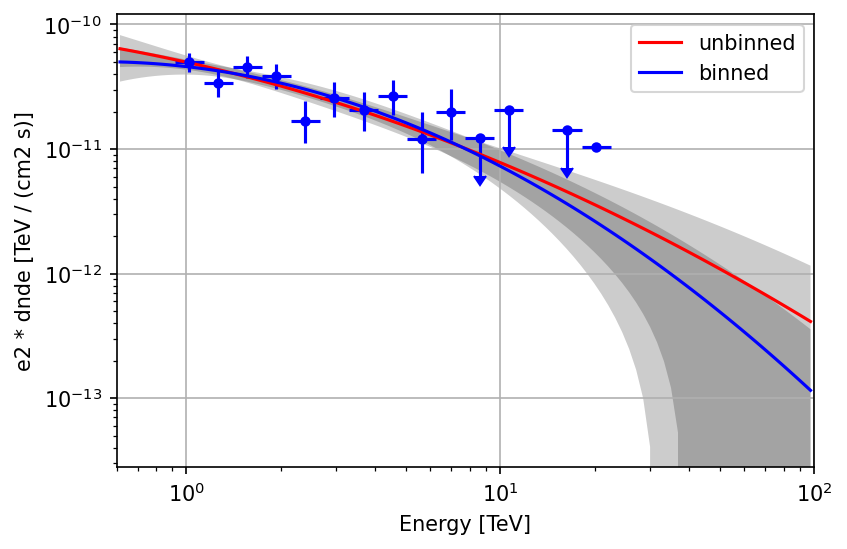

In [20]:
plt.figure(dpi=150)
fp.plot(color='blue', energy_power=2)
kwargs = dict(energy_bounds=[0.6,100]*u.TeV, energy_power=2)
eds.models['crab_model_gauss'].spectral_model.plot(label='unbinned', c='r', **kwargs)
dataset.models['crab_model_gauss'].spectral_model.plot(label='binned', c='b', **kwargs)
eds.models['crab_model_gauss'].spectral_model.plot_error(color='red', **kwargs)
dataset.models['crab_model_gauss'].spectral_model.plot_error(color='blue', **kwargs)
plt.legend()
plt.grid()

In [21]:
# compute the contributions to the total likelihood for each event
contrib=eds.contribution_events()
contrib_bins, ind, co = eds.contribution_bins()

In [22]:
### check the sum of the contributions
### difference for binned because of empty bins
contrib.sum(), eds.stat_sum(), contrib_bins.sum(), eds.ds.stat_sum()

(14267.940979312427, 10684.169941751818, 8246.87905181426, 10722.26736887076)

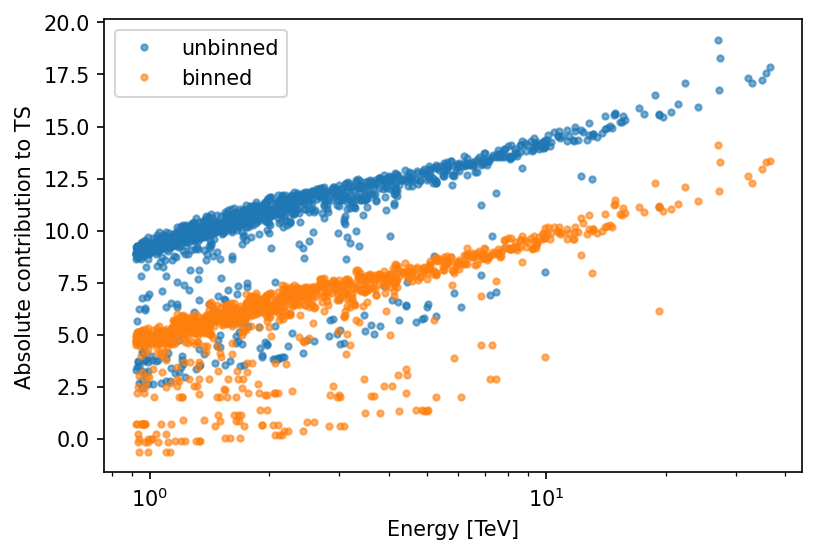

In [23]:
plt.figure(dpi=150)
plt.semilogx(eds.tab["ENERGY"], contrib, ls='None', marker='.', alpha=0.6, label='unbinned')
plt.semilogx(eds.tab["ENERGY"], contrib_bins, ls='None', marker='.', alpha=0.6, label='binned')
plt.xlabel('Energy [TeV]')
plt.ylabel("Absolute contribution to TS")
plt.legend()

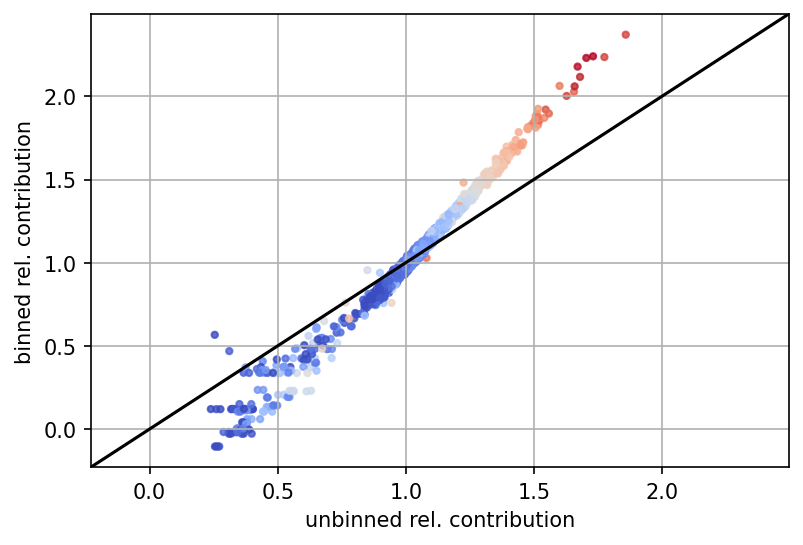

In [24]:
plt.figure(dpi=150)

colormap = plt.cm.coolwarm
colorst = np.log(eds.tab["ENERGY"])
colorst /= colorst.max()

plt.scatter(contrib/contrib.sum()*len(contrib), 
         contrib_bins/contrib_bins.sum()*len(contrib_bins), 
         ls='None', marker='.', color=colormap(colorst), alpha=0.8)
ax = plt.gca()



xlim=ax.get_xlim()
ylim=ax.get_ylim()
sq_lim = min(ylim[0],xlim[0]), max(ylim[1],xlim[1])

plt.plot(sq_lim,sq_lim, c='k')
plt.xlabel('unbinned rel. contribution')
plt.ylabel('binned rel. contribution')
plt.xlim(sq_lim)
plt.ylim(sq_lim)
plt.grid()

# Test of significances

In [25]:
# test of the source significance
ts_binned = dataset.stat_sum()
ts_unb = eds.stat_sum()
print(f"TS_binned = {ts_binned:.2f}; TS_unbinned = {ts_unb:.2f}")
with dataset.models.parameters.restore_status():
    dataset.models.parameters['amplitude'].value = 0
    dataset.models.parameters['amplitude'].frozen = True
    res=fit.optimize(dataset)
    ts_binned0 = res.total_stat
with eds.models.parameters.restore_status():
    eds.models.parameters['amplitude'].value = 0
    eds.models.parameters['amplitude'].frozen = True
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res2=fit.optimize([eds])
    ts_unb0 = res2.total_stat
      
print(f"deltaTS_binned = {ts_binned0-ts_binned:.5f}")
print(f"deltaTS_unbinned = {ts_unb0-ts_unb:.5f}")

TS_binned = 10721.32; TS_unbinned = 10684.17
deltaTS_binned = 498.44596
deltaTS_unbinned = 505.92806


In [26]:
# test of the curvature (beta) significance
ts_binned = dataset.stat_sum()
ts_unb = eds.stat_sum()
print(f"TS_binned = {ts_binned:.2f}; TS_unbinned = {ts_unb:.2f}")
with dataset.models.parameters.restore_status():
    dataset.models.parameters['beta'].value = 0
    dataset.models.parameters['beta'].frozen = True
    res=fit.optimize(dataset)
    ts_binned0 = res.total_stat
with eds.models.parameters.restore_status():
    eds.models.parameters['beta'].value = 0
    eds.models.parameters['beta'].frozen = True
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res2=fit.optimize([eds])
    ts_unb0 = res2.total_stat
      
print(f"deltaTS_binned = {ts_binned0-ts_binned:.5f}")
print(f"deltaTS_unbinned = {ts_unb0-ts_unb:.5f}")

TS_binned = 10721.32; TS_unbinned = 10684.17
deltaTS_binned = 2.01350
deltaTS_unbinned = 0.50884


/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


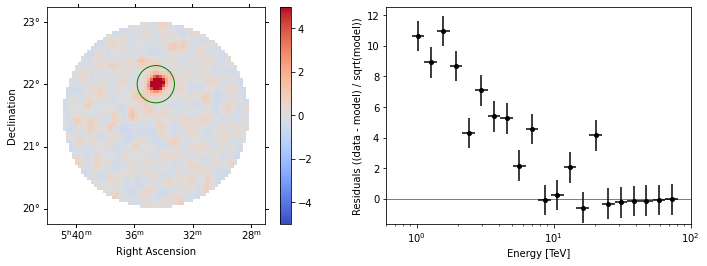

In [27]:
with model_gauss.parameters.restore_status():
    model_gauss.parameters['amplitude'].value = 0
    dataset.plot_residuals(kwargs_spectral={'region':circle, 'method':'diff/sqrt(model)'},
                          kwargs_spatial=dict(vmin=-5,vmax=5, smooth_radius='0.05 deg',method='diff/sqrt(model)'))

# some timing tests

In [28]:
# time for binned dataset
%timeit dataset.stat_sum()

4.06 ms ± 35.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
# time for unbinned dataset
%timeit eds.stat_sum()

4.54 ms ± 50.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
